In [185]:
%matplotlib inline
import pandas as pd
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import heatmap as hm
import feature as ft
import seaborn as sns
import math

In [4]:
a = hm.IVIS()
a.gt_df.head()

,eventid,year,country,region,latitude,longitude,attacktype,casualties,wounds
0,197000000001,1970,Dominican Republic,Central America & Caribbean,18.456792,-69.951164,Assassination,1.0,0.0
1,197000000002,1970,Mexico,North America,19.432608,-99.133207,Hostage Taking (Kidnapping),0.0,0.0
2,197001000001,1970,Philippines,Southeast Asia,15.478598,120.599741,Assassination,1.0,0.0
3,197001000002,1970,Greece,Western Europe,37.983773,23.728157,Bombing/Explosion,NaN,NaN
4,197001000003,1970,Japan,East Asia,33.580412,130.396361,Facility/Infrastructure Attack,NaN,NaN


In [7]:
dot_plot_features = ['country', 'year', 'attacktype', 'casualties']
gtd_dot = a.gt_df[dot_plot_features]
gtd_dot.head()

,country,year,attacktype,casualties
0,Dominican Republic,1970,Assassination,1.0
1,Mexico,1970,Hostage Taking (Kidnapping),0.0
2,Philippines,1970,Assassination,1.0
3,Greece,1970,Bombing/Explosion,NaN
4,Japan,1970,Facility/Infrastructure Attack,NaN


In [9]:
def create_counts(data, group_by_columns, column_to_count):
    '''Takes a list of column names and a column to count and counts rows by those column name, including nulls'''
    all_columns = group_by_columns + [column_to_count]
    data = data.loc[:,all_columns].fillna(value = 1)
    grouped = data.groupby(group_by_columns)
    return grouped.count()

In [191]:
data = create_counts(gtd_dot, ['country', 'year', 'attacktype'], 'casualties')
data.head()

casualties
country     year attacktype                             
Afghanistan 1973 Unknown                               1
            1979 Armed Assault                         1
                 Bombing/Explosion                     1
                 Hostage Taking (Kidnapping)           1
            1987 Unarmed Assault                       1

In [11]:
def unstack_table(data):
    data = data.fillna(0)
    i = 0
    while i < data.index.nlevels:
        data = data.unstack()
        i = i + 1
    return data

In [12]:
data = unstack_table(data)

In [13]:
data.head()

casualties                                               ...    \
attacktype  Armed Assault                                               ...     
year                 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979  ...     
country                                                                 ...     
Afghanistan           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  ...     
Albania               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...     
Algeria               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...     
Andorra               NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  ...     
Angola                NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  1.0  ...     

                                                                            
attacktype  Unknown                                                         
year           2006 2007  2008  2009  2010  2011  2012  2013   2014   2015  
country                                                                     
Afghanistan     9.0  7.0  18.0  11.0  26.0  15.0  74.0  74.0  163.0  186.0  
Albania         NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN  
Algeria         2.0  2.0   4.0   2.0   2.0   1.0   2.0   NaN    1.0    3.0  
Andorra         NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN  
Angola          NaN  NaN   NaN   NaN   1.0   NaN   NaN   NaN    NaN    NaN  

[5 rows x 405 columns]

In [151]:
class Dot_Plot_Data():
    def __init__(self, data, yaxis_vals, xaxis_vals, user_filter1, user_filter2):
        '''Defines attributes of the dot plot'''
        self.data = data[[yaxis_vals, xaxis_vals, user_filter1, user_filter2]]
        self.yaxis_vals = yaxis_vals
        self.user_filter1 = user_filter1
        self.user_filter2 = user_filter2
    
    def restructure_data(self):
        '''Pivots and unstacks data'''
        self.data = pd.pivot_table(self.data, index=[self.yaxis_vals, self.user_filter1, self.user_filter2], aggfunc=sum).dropna()
        self.data = unstack_table(self.data)
        
    #not using Viola's year_selection function b/c it was written when we thought we'd have text selections    
    def user_selection(self, year_tuple, attack_type):
        #May use general terms to make this code more reusable
        '''Selects year and attack type'''
        years = tuple(range(year_tuple[0], year_tuple[1]))
        self.data = self.data.loc[:, (slice(None), attack_type, years)]
    
    def agg(self):
        self.data = self.data.sum(axis=1)

In [160]:
dot_plot = Dot_Plot_Data(a.gt_df, 'country', 'casualties', 'year', 'attacktype')

In [122]:
attacktypes = list(set(dot_plot.data['attacktype']))

In [161]:
dot_plot.restructure_data()
dot_plot.data.head()

In [163]:
dot_plot.user_selection([2010, 2015], 'Armed Assault')
dot_plot.data.head()

casualties                                
attacktype  Armed Assault                                
year                 2010   2011     2012    2013    2014
country                                                  
Afghanistan         189.0  179.0  1032.83  1301.5  1712.0
Albania               NaN    NaN      NaN     NaN     NaN
Algeria              23.0   19.0    10.00    11.0    24.0
Angola                2.0    NaN      NaN     NaN     NaN
Argentina             NaN    NaN      NaN     0.0     NaN

In [164]:
dot_plot.agg()
dot_plot.data.head()

country
Afghanistan    4414.33
Albania           0.00
Algeria          87.00
Angola            2.00
Argentina         0.00
dtype: float64

In [165]:
def remove_zeros(series):
    return series[series > 0]

In [167]:
casualties = remove_zeros(dot_plot.data)

In [168]:
def convert_series(series, label):
    '''Takes a series and label for the series' values, returns df with 2 columns: the series' row index, & the series' values'''
    converted = pd.DataFrame(series)
    converted.columns = [label]
    converted.reset_index(level=0, inplace=True)
    return converted

In [169]:
casualties = convert_series(casualties, 'Casualties from Armed Assault')

In [81]:
def year_interval():
    yr_interval = widgets.IntRangeSlider(value=[1970, 2015],
                                 min=1970,
                                 max=2015,
                                 step=1,
                                 description='Year:',
                                 disabled=False,
                                 continuous_update=False,
                                 orientation='horizontal',
                                 readout=True,
                                 readout_format='i',
                                 slider_color='white',
                                 color='black')
    #yr_interval.layout.width = '80%'
    return yr_interval

In [132]:
def attack_type():
    attack_type = widgets.Dropdown(
                                options=attacktypes,
                                value='Armed Assault',
                                description='Number:',
                                disabled=False,
                                button_style='info') # 'success', 'info', 'warning', 'danger' or ''
    return attack_type

In [186]:
def plot(attacktype, year_range):
    
    dot_plot = Dot_Plot_Data(a.gt_df, 'country', 'casualties', 'year', 'attacktype')
    dot_plot.restructure_data()
    
    dot_plot.user_selection(year_range, attacktype)
    dot_plot.agg()
    series = remove_zeros(dot_plot.data)
    casualties = convert_series(series, 'Casualties from ' + attacktype)
    casualties = casualties.sort_values('Casualties from ' + attacktype, ascending=False).iloc[0:20, :]
    
    sns.set(style="whitegrid")
    
    # Make the PairGrid
    g = sns.PairGrid(casualties,
                     x_vars='Casualties from ' + attacktype, y_vars=['country'],
                     size=12, aspect=.50)

    # Draw a dot plot using the stripplot function
    g.map(sns.stripplot, size=10, orient="h",
          palette="Reds_r", edgecolor="gray")
    
    xmax = math.ceil(max(casualties['Casualties from ' + attacktype])/500)*500

    # Use the same x axis limits on all columns and add better labels
    g.set(xlim=(0, xmax), xlabel="Casualties", ylabel="")

    # Use semantically meaningful titles for the columns
    titles = ['Top Countries by' + attacktype + ' Casualties']

    for ax, title in zip(g.axes.flat, titles):

        # Set a different title for each axes
        ax.set(title=title)

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

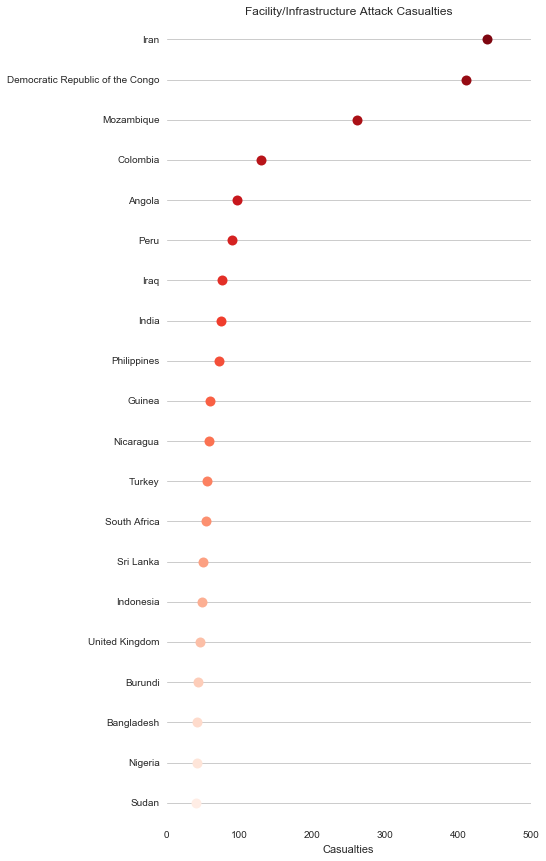

In [188]:
#it's having a really hard time keeping up when it has to recalculate, might need the "execute" button
interact(plot, attacktype = attack_type(), year_range = year_interval(),__manual=True);